# Human face emotions classification (part of affectnet dataset, contains 8 classes: neutral, happy, sad, surprise, fear, disgust, anger, contempt)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, recall_score, accuracy_score, precision_score, f1_score
from typing import List, Dict, Tuple, Callable
from copy import deepcopy
import copy

Read(create) data

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data_dir = 'drive/MyDrive/emotions_ds'

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [6]:
image_data = {x: datasets.ImageFolder(os.path.join(data_dir, x + "_class"),
                                          data_transforms[x])
                  for x in ['train', 'val']}

class_names = image_data['train'].classes

data_size = {x: len(image_data[x]) for x in ['train', 'val']}

batch_size=64
dataloaders = {x: torch.utils.data.DataLoader(image_data[x], batch_size=batch_size, shuffle=True, num_workers=8)   
               for x in ['train', 'val']}

print(data_size)
print(device)
print(class_names)

{'train': 37553, 'val': 4000}
cuda:0
['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Using pre-trained model to quickly obtain cutting-edge results                

VGG

In [7]:
#inception_model = models.inception_v3(pretrained=True)
#inception_model.aux_logits = False
vgg16 = models.vgg16(pretrained=True)
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
#for param in inception_model.parameters():
#    param.requires_grad = False
for param in vgg16.parameters():    
  param.requires_grad = False

In [13]:
#inception_model.fc = nn.Sequential(nn.Linear(2048, 128), nn.ReLU(), nn.Linear(128, len(class_names)), nn.LogSoftmax(dim=1))
vgg16.classifier[6] = nn.Linear(4096, len(class_names))
vgg16.classifier.add_module('8', nn.LogSoftmax(dim=1))
if torch.cuda.is_available():
    vgg16.cuda()
criterion = nn.NLLLoss()
optimizer = optim.Adam(vgg16.parameters())

In [12]:
#inception_model.cuda()

Train model

In [14]:
def train_model(base_model, criterion, optimizer, num_epochs=5):    
  best_model_wts = copy.deepcopy(base_model.state_dict())
  best_acc = 0.0
  loss_list=[]
  acc=[]
  for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0
    
    print('Epoch {}/{}'.format(epoch + 1, num_epochs))
    print('-' * 10)

    base_model.train()

    for img, labels in dataloaders['train']:
      img, labels = img.cuda(), labels.cuda()
      img = img.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      output = base_model(img)
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item() * img.size(0)
      _, pred = torch.max(output, dim=1)
      correct_tensor = pred.eq(labels.data.view_as(pred))
      accuracy = torch.mean(correct_tensor.type(torch.cuda.FloatTensor))
      train_acc += accuracy.item() * img.size(0)
 
    train_loss = train_loss / len(image_data['train']) 
    train_acc = train_acc / len(dataloaders['train'].dataset)
    loss_list.append(train_loss)
    acc.append(train_acc)
    print(f'Training Loss: {train_loss:.4f}')
    print(f'Training Accuracy: {100 * train_acc:.2f}')
    if epoch >= 1:
      if train_loss > loss_list[-2]:
        #return best_model_wts, loss_list
        best_model_wts = copy.deepcopy(base_model.state_dict())
    
  #return base_model, loss_list
  base_model.load_state_dict(best_model_wts)
  return base_model

In [15]:
trained_model = train_model(vgg16, criterion, optimizer)

Epoch 1/5
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training Loss: 2.0639
Training Accuracy: 21.29
Epoch 2/5
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5d317f2e60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.7/multiprocessing/popen_fork.py", line 45, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 921, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.7/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


KeyboardInterrupt: ignored

VGG **wasn't** a good idea

**Resnet**

In [18]:
resnet_model = models.resnet152(pretrained=True)
for param in resnet_model.parameters():
  param.requires_grad = False
resnet_model.fc = nn.Sequential(nn.Linear(2048, 128), nn.ReLU(), nn.Linear(128, len(class_names)), nn.LogSoftmax(dim=1))
resnet_model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet_model.parameters()), lr=0.001)

In [19]:
resnet_model_trained = train_model(resnet_model, criterion, optimizer)

Epoch 1/5
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training Loss: 1.9175
Training Accuracy: 25.80
Epoch 2/5
----------
Training Loss: 1.8397
Training Accuracy: 29.64
Epoch 3/5
----------
Training Loss: 1.8219
Training Accuracy: 30.56
Epoch 4/5
----------
Training Loss: 1.8085
Training Accuracy: 31.13
Epoch 5/5
----------
Training Loss: 1.7969
Training Accuracy: 31.31


In [21]:
def predict():
  all_preds = torch.tensor([]).to(device)
  true_vals = torch.tensor([]).to(device)
  test_acc=0
  with torch.no_grad():
    for (X, y) in dataloaders['val']:
      X, y = X.to(device), y.to(device)
      true_vals = torch.cat((true_vals, y), 0)
      pred = resnet_model_trained(X)
      _, pred = torch.max(pred, dim=1)
      all_preds = torch.cat((all_preds, pred), 0)

      correct_tensor = pred.eq(y.data.view_as(pred))
      accuracy = torch.mean(correct_tensor.type(torch.cuda.FloatTensor))
      test_acc += accuracy.item()* X.size(0)
    
      
    test_acc = test_acc / len(dataloaders['val'].dataset)
    print(f'    Testing Accuracy: { test_acc:.2f}')
    return all_preds.cpu().numpy(), true_vals.cpu().numpy()
      
outputs, labels = predict()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


    Testing Accuracy: 0.12



# Classification report and ROC curves

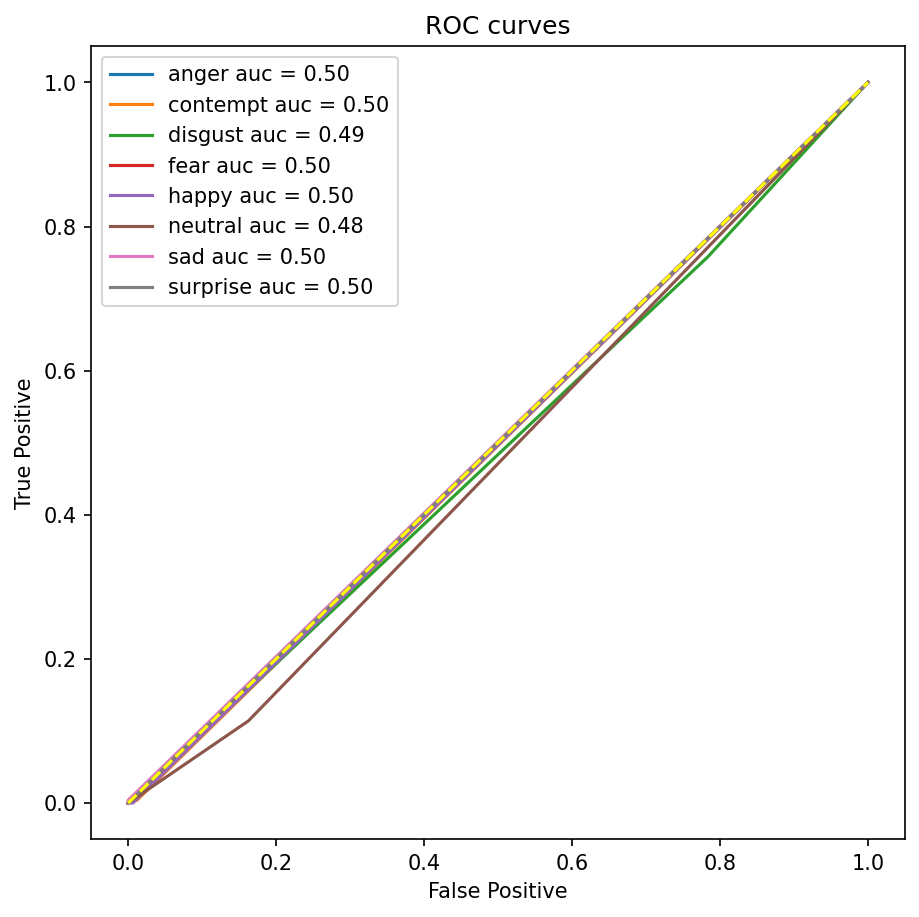

In [28]:
lab_plt = [(labels == i).astype(float) for i in range(8)]
outs_plt = [(outputs == i).astype(float) for i in range(8)]
fpr = {}
tpr = {}
roc_auc = {}
for i in range(8):
    fpr[i], tpr[i], _ = roc_curve(lab_plt[i], outs_plt[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure (figsize = (7, 7), dpi = 150)
for i in range(8):
  plt.plot(fpr[i], tpr[i], label = f'{class_names[i]} auc = {roc_auc[i]:.2f}' )
plt.legend(loc = 'best')
plt.plot([0,1], [0,1], color='yellow', linestyle='--')
plt.title('ROC curves')
plt.ylabel('True Positive')
plt.xlabel('False Positive')
plt.show()

In [30]:
print(classification_report(labels, outputs, target_names=class_names))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       500
    contempt       0.05      0.00      0.01       500
     disgust       0.12      0.76      0.21       500
        fear       0.00      0.00      0.00       500
       happy       0.00      0.00      0.00       500
     neutral       0.09      0.11      0.10       500
         sad       1.00      0.00      0.01       500
    surprise       0.13      0.05      0.07       500

    accuracy                           0.12      4000
   macro avg       0.17      0.12      0.05      4000
weighted avg       0.17      0.12      0.05      4000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Visualizing model predictions

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


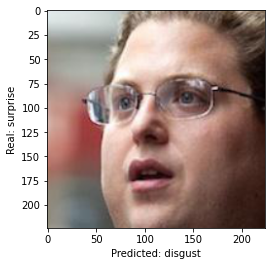

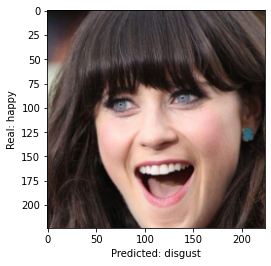

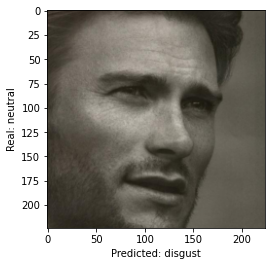

In [32]:
k = 0
n=3
for img, lab in dataloaders['val']: 
  image = img 
  img = img.to(device)
  pred = resnet_model_trained(img)
  _, pred = torch.max(pred, dim=1)
  k += 1
  for i in range(n):
    inp = torchvision.utils.make_grid(image[i]).numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.ylabel('Real: {}'.format(class_names[lab[i]]))
    plt.xlabel('Predicted: {}'.format(class_names[pred[i]]))
    plt.imshow(inp)
  plt.show()
  if k == n:
      break

# Summary
To sum up, frankly speaking, we have got bad results.If we compare results with this data to previous, it's really bad. Because of small difference besides classes in emotions_ds instead of obvious in natural scenes. Moreover, a lot of photos are distributed incorrectly. I suppose that if we add clearer images into dataset and use another pre-trained model (InceptionV3) we'll get better results.